<a href="https://colab.research.google.com/github/hdavidkang/hdavidkang-DS-Merchant-Transaction-Findout/blob/main/Merchant_Transaction_Findout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FinTech Merchant Transaction - who is who?

## Data Import

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import OrderedDict
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/takehome_ds_written.csv').iloc[:, 1:]
data.columns = ['id', 'time', 'usd']
data['time'] = data.time.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
data['usd'] = data.usd/100
data = data.sort_values(by='time').reset_index(drop=True)
data.head(3)

,id,time,usd
0,3e72388b82,2033-01-01 09:38:32,43.35
1,32cd721943,2033-01-01 12:53:52,60.19
2,a8ff2d667e,2033-01-01 15:08:55,39.42


In [ ]:
len(data), data.id.nunique() # 1.5M, 12K

(1513719, 14351)

## Part 1. Merchant Types

**Mechant Type 1. Ride Biz (Uber, Lyft)**

*   Peak hours (7 - 9 am & 5 - 7pm weekdays, 5 pm - 5 am weekends)
*   Price range (ATV: 10 to 50 USD, max < 100 USD)


Reference: [Uber website](https://www.uber.com/en-AU/blog/making-the-most-of-your-time-on-the-road/)



In [ ]:
    ## We assign +1 point for transactions in this regime

weekdays = [0, 1, 2, 3, 6]
weekends = [4, 5]

weekday_peak_hrs = [7, 8, 17, 18]
weekend_peak_hrs = [17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4]

weekday_peak = (data.time.dt.weekday.apply(lambda x: x in weekdays)) & (data.time.dt.hour.apply(lambda x: x in weekday_peak_hrs))
weekend_peak = (data.time.dt.weekday.apply(lambda x: x in weekends)) & (data.time.dt.hour.apply(lambda x: x in weekend_peak_hrs))

ride_biz_point = (weekday_peak) | (weekend_peak)
data['ride_biz_point'] = ride_biz_point

    # Now calculate the probability of a merchant being in the ride business
    # Note that we should normalize points with total hours -> call it density

peak_rides_density = data.groupby('id').sum().ride_biz_point / (len(weekday_peak_hrs)*len(weekdays) + len(weekend_peak_hrs)*len(weekends))
total_rides_density = data.groupby('id').count().ride_biz_point / (24*7)
ride_biz_bool =  (peak_rides_density / total_rides_density) > 0.7

ATV = data.groupby('id').sum().usd / data.groupby('id').count().usd 
ATV_bool = (10 <= ATV) & (ATV <= 50)

ride_biz_list = list(set(ride_biz_bool[ride_biz_bool].index) & set(ATV_bool[ATV_bool].index))

**Merchant Type 2. E-commerce & Retail (Amazon, Shopify)**

*   ATV (average transaction value) in 75 ~ 102 USD range.
*   Sales dramatically peak in December.

Reference: [Adobe Biz Intelligence website](https://business.adobe.com/products/magento/business-intelligence.html)


In [ ]:
## ATV
ATV_bool = (75 <= ATV) & (ATV <= 102)

## DEC peak
DEC_sales = data[data.time.dt.month == 12].groupby('id').sum().usd/1
REG_sales = data[data.time.dt.month != 12].groupby('id').sum().usd/11

DEC_REG_merged = pd.merge(DEC_sales, REG_sales, on = 'id')
DEC_peak_bool = (DEC_REG_merged.usd_x / DEC_REG_merged.usd_y) > 10
DEC_peak_bool.name = 'usd'

## Combine
eCommerce = pd.merge(ATV_bool, DEC_peak_bool, on = 'id')
ATV_DEC = (eCommerce.usd_x) & (eCommerce.usd_y)
eCommerce_list = list(ATV_DEC[ATV_DEC].index) 

**Merchant Type 3. Enterprise (Google, Microsoft)**

*   Corporations with large market cap will likely be the only ones who can easily spend more than 10 K USD per transaction.

Basis: My assumption

In [ ]:
enterprise_bool = (ATV > 20*1e3)
enterprise_list = list(enterprise_bool[enterprise_bool].index)
len(enterprise_list)

5

**Merchant Type 4. Travel Agencies (Expedia, Bookings.com)**

*   A peculiar aspect of travel agencies' quarterly revenue is that it spikes in September.

Reference: [Quarterly revenue history](https://www.google.com/search?q=expedia+revenue+by+quarter&bih=853&biw=1527&hl=en&sxsrf=APq-WBuRUhRdkozPPwG4wcCH_ITNGx738A%3A1648153193388&ei=adI8YsaYF8KnptQPvciO6AI&ved=0ahUKEwiG8YGNyd_2AhXCk4kEHT2kAy0Q4dUDCA4&uact=5&oq=expedia+revenue+by+quarter&gs_lcp=Cgdnd3Mtd2l6EAMyCAghEBYQHRAeOgcIIxCwAxAnOgcIABBHELADOgYIABAWEB5KBAhBGABKBAhGGABQdli_B2C9CmgBcAF4AIABRIgBmgOSAQE3mAEAoAEByAEJwAEB&sclient=gws-wiz)

In [ ]:
SEP_sales = data[data.time.dt.month == 9].groupby('id').sum().usd/1
REG_sales = data[data.time.dt.month != 9].groupby('id').sum().usd/11

SEP_REG_merged = pd.merge(SEP_sales, REG_sales, on = 'id')
SEP_peak_bool = (SEP_REG_merged.usd_x / SEP_REG_merged.usd_y) > 10
SEP_peak_bool.name = 'usd'

travel_agency_list = list(SEP_peak_bool[SEP_peak_bool].index) 

**Merchant Type 5. Growth Companies (Zillow, Slack)**

*   Growth companies are normally defined as ones that show more than 20% growth YoY
*   We include startups, but exclude Enterprise.

In [ ]:
year2033 = (data.time.dt.year == 2033)
rev_2033 = data[year2033].groupby('id').sum().usd
rev_2034 = data[~year2033].groupby('id').sum().usd

rev_merged = pd.merge(rev_2033, rev_2034, on = 'id')
growth_bool = (rev_merged.usd_y / rev_merged.usd_x) > 1.20
growth_bool.name = 'usd'

growth_MEDSMALL = pd.merge(growth_bool, ~enterprise_bool, on = 'id')
growth_bool = (growth_MEDSMALL.usd_x) & (growth_MEDSMALL.usd_y)

growth_company_list = list(growth_bool[growth_bool].index)

In [ ]:
len(ride_biz_list), len(eCommerce_list), len(enterprise_list), len(travel_agency_list), len(growth_company_list)

(1841, 113, 5, 448, 2837)

## Sample visuals

### Merchant Type 1. Ride Apps

In [ ]:
rides = data[data.id.isin(ride_biz_list)]

Text(0, 0.5, 'Transactions (USD)')

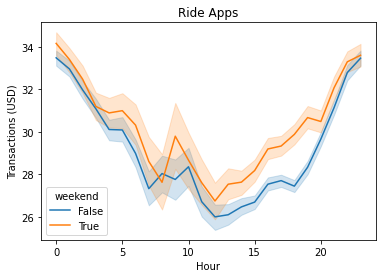

In [ ]:
%%capture --no-display
rides = rides[(rides.usd < 100)]
rides['weekend'] = rides.time.dt.weekday.isin({4, 5})
rides['hour'] = rides.time.dt.hour

fig = sns.lineplot(data=rides, x="hour", y="usd", hue="weekend").set_title('Ride Apps')
plt.xlabel('Hour')
plt.ylabel('Transactions (USD)')

### Merchant Type 2. E-commerce & Retail

In [ ]:
retails = data[data.id.isin(eCommerce_list)]

Text(0, 0.5, 'ATV (USD)')

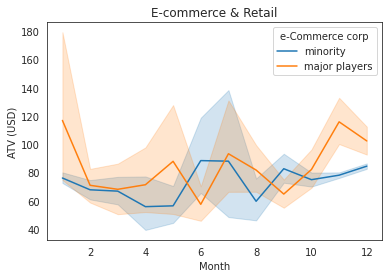

In [ ]:
%%capture --no-display
ATV_retails = retails.groupby('id').sum().usd / retails.groupby('id').count().usd
major_retails_list = ATV_retails[ATV_retails.apply(lambda x: True if x >= 95 else False)]

retails['e-Commerce corp'] = data.id.apply(lambda x: 'major players' if x in major_retails_list else 'minority')
retails['month'] = retails.time.dt.month

sns.set_style("white")
fig = sns.lineplot(data=retails, x="month", y="usd", hue="e-Commerce corp").set_title('E-commerce & Retail')
plt.xlabel('Month')
plt.ylabel('ATV (USD)')

### Merchant Type 3. Enterprise

In [ ]:
enterprises = data[data.id.isin(enterprise_list)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'T-test Pass rate')

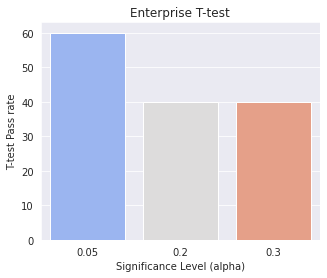

In [ ]:
df_ent = enterprises.pivot_table(index = 'id', columns = 'time', values = 'usd', fill_value = np.NaN)

df_ent['sample_mean'] = df_ent.sum(axis=1)/df_ent.T.count()
mean_under_H0 = 20*1e3
df_ent['sample_std'] = np.sqrt((df_ent ** 2).sum(axis=1) - df_ent.T.count()*((df_ent.sum(axis=1)/df_ent.T.count())**2))
df_ent['pval'] = 1 - stats.t.cdf((df_ent.sample_mean - mean_under_H0)/(df_ent.sample_std/np.sqrt(df_ent.T.count())), df_ent.T.count()-1)
test_alphas = np.array([0.3, 0.2, 0.05])
df_ent[['alpha1', 'alpha2', 'alpha3']] = test_alphas

passed = np.array([sum(df_ent.pval < df_ent.alpha3)/len(df_ent)*100, sum(df_ent.pval < df_ent.alpha2)/len(df_ent)*100, sum(df_ent.pval < df_ent.alpha1)/len(df_ent)*100])
sns.set_style('darkgrid')
plt.figure(figsize=(5,4))
fig = sns.barplot(test_alphas, passed, palette = 'coolwarm').set_title('Enterprise T-test')
plt.xlabel('Significance Level (alpha)')
plt.ylabel('T-test Pass rate')

### Merchant Type 4. Travels

In [ ]:
travels = data[data.id.isin(travel_agency_list)]

Text(0, 0.5, 'Total transaction (USD)')

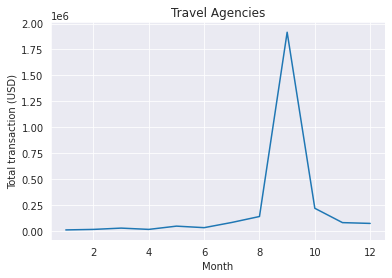

In [ ]:
%%capture --no-display
travels['month'] = travels.time.dt.month
df_travels = travels.groupby('month').sum().reset_index()
fig = sns.lineplot(data = df_travels, x = 'month', y = 'usd').set_title('Travel Agencies')
plt.xlabel('Month')
plt.ylabel('Total transaction (USD)')

### Merchant Type 5. Growth Companies

In [ ]:
growths = data[data.id.isin(growth_company_list)]

Text(0, 0.5, 'Transactions (1e7 USD)')

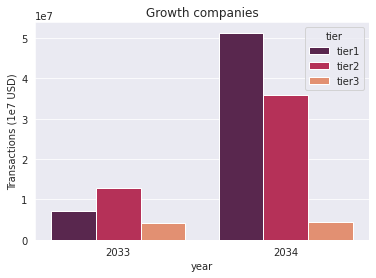

In [ ]:
%%capture --no-display
growths['year'] = growths.time.dt.year
df_growths = growths.groupby(['id', 'year']).sum()
df_growths['tier'] = df_growths.usd.apply(lambda x: 'tier1' if x > 100*1e3 else ('tier3' if x < 10*1e3 else 'tier2'))           

fig = sns.barplot(data = df_growths.groupby(['year', 'tier']).sum().reset_index(), x = 'year', y = 'usd', hue = 'tier', palette = 'rocket').set_title('Growth companies')
plt.ylabel('Transactions (1e7 USD)')

## Part 2. Define, Identify, and Predict churn

### 2.1. Define churn

#### (a) Type 1. Duration churn
Since the last transaction, no further transaction has occurred for more than the maximum interval observed.

#### (b) Type 2. Dollar churn
There is a clear sign of decay in transaction USD amount, i.e., at least 50% decay for more than 3 consecutive latest transactions.

### 2.2. Identify churn

In [ ]:
# Set 8 features for churn identification, which will be used for prediection as well

id = pd.Series(data.id.unique()).apply(lambda x: x)
merchant_type = pd.Series(data.id.unique()).apply(lambda x: 'Ride_App' if x in ride_biz_list else('eCommerce_Retail' if x in eCommerce_list else('Travels' if x in travel_agency_list else ('growth_compnay_list' if x in growth_company_list else 'Enterprise'))))
span = (data.groupby('id').max().time - data.groupby('id').min().time).dt.days
atv = data.groupby('id').mean().usd 
freq = (data.groupby('id').count().usd / span).replace(np.inf, 0) # [number/day]
data['diffr'] = data.sort_values('id').reset_index().time - data.sort_values('id').reset_index().time.shift(1)
max_interval = data.groupby('id').max().diffr.dt.days.apply(lambda x: 0 if x < 0 else x) 
since_last_trans = (data.groupby('id').max().time - data.time.min()).dt.days 

last1 = data.sort_values(['id', 'time']).groupby('id').nth(-3).usd
last2 = data.sort_values(['id', 'time']).groupby('id').nth(-2).usd
last3 = data.sort_values(['id', 'time']).groupby('id').nth(-1).usd

In [ ]:
# Identify churn
type1_churn = (max_interval < since_last_trans)
type1_churn_list = list(type1_churn[type1_churn].index)

type2_churn = ((last2-last1)/last2 >= 0.5) & ((last3-last2)/last3 >= 0.5)
type2_churn_list = list(type2_churn[type2_churn].index)

print(f'There exists {len(type1_churn_list)} cases of type 1 and {len(type2_churn_list)} cases of type 2 churns.')

There exists 13044 cases of type 1 and 191 cases of type 2 churns.


Text(0, 0.5, 'Transactions (USD)')

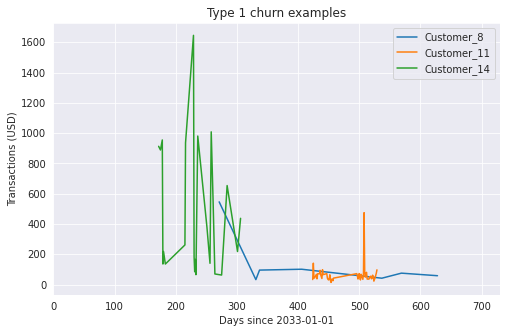

In [ ]:
# Example graph - churn type 1

fig, ax = plt.subplots(figsize = (8,5))
type1_examples = [8, 11, 14]

for elm in type1_examples:
  type1_sample = data[data.id == type1_churn_list[elm]][['time', 'usd']].reset_index(drop=True)
  type1_sample['days'] = (type1_sample.time - np.datetime64('2033-01-01')).apply(lambda x: x.days)
  fig = sns.lineplot(data = type1_sample, x = 'days', y = 'usd', ci = None, label = 'Customer_'+str(elm)).set_title('Type 1 churn examples')

ax.set_xlim(0, 365*2)
plt.xlabel('Days since 2033-01-01')
plt.ylabel('Transactions (USD)')

Text(0, 0.5, 'Transactions (USD)')

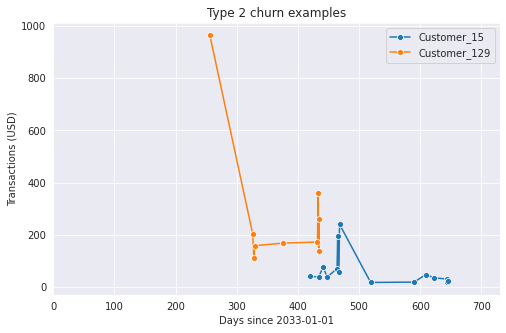

In [ ]:
# Example graph - churn type 2

fig, ax = plt.subplots(figsize = (8,5))
type2_examples = [15, 129]

for elm in type2_examples:
  type2_sample = data[data.id == type2_churn_list[elm]][['time', 'usd']].reset_index(drop=True)
  type2_sample['days'] = (type2_sample.time - np.datetime64('2033-01-01')).apply(lambda x: x.days)
  fig = sns.lineplot(data = type2_sample, x = 'days', y = 'usd', ci = None, marker = 'o', label = 'Customer_'+str(elm)).set_title('Type 2 churn examples')

ax.set_xlim(0, 365*2)
plt.xlabel('Days since 2033-01-01')
plt.ylabel('Transactions (USD)')

### 2.3. Predict churn

#### Construct & Pre-process data

In [ ]:
# Construct
merchant_type.index = id
merchant = pd.DataFrame(span).reset_index().id.apply(lambda x: merchant_type[str(x)])
merchant.name = 'merchant'

freq.name, span.name, atv.name, max_interval.name, since_last_trans.name = 'freq', 'span', 'atv', 'max_interval', 'since_last_trans'

temp = pd.concat([span, atv, freq, max_interval, since_last_trans], axis=1).reset_index()
df = pd.concat([temp, merchant], axis=1)

df['churn_type_1'] = df.id.apply(lambda x: True if x in type1_churn_list else False)
df['churn_type_2'] = df.id.apply(lambda x: True if x in type2_churn_list else False)
df['churn'] = (df.churn_type_1 | df.churn_type_2)

decay1, decay2 = last1/last2, last2/last3

df['decay1'] = df.id.apply(lambda x: decay1[str(x)] if x in list(decay1.index) else 0).fillna(0)
df['decay2'] = df.id.apply(lambda x: decay2[str(x)] if x in list(decay2.index) else 0).fillna(0)

df.head(3)

,id,span,atv,freq,max_interval,since_last_trans,merchant,churn_type_1,churn_type_2,churn,decay1,decay2
0,0002b63b92,0,33.790000,0.000000,0,135,Enterprise,True,False,True,0.000000,0.000000
1,0002d07bba,64,223.195000,0.062500,331,713,Enterprise,True,False,True,0.862871,21.313563
2,00057d4302,66,10.543214,0.424242,342,214,Enterprise,False,False,False,1.384097,0.594551


In [ ]:
# Pre-process

## 1. One-Hot Encode Categorical Data
merch_cat = pd.get_dummies(df.merchant)

## 2. Normalize Data
## - Unnecessary for tree-based models (GBDT), but it will be useful for other ML algos, such as NN
temp = df.drop(columns = ['id', 'merchant', 'churn_type_1', 'churn_type_2', 'churn'])
norm = (temp - temp.min())/(temp.max() - temp.min())

## 3. define x, y
x = pd.concat([norm, merch_cat], axis=1)
y = df.churn.astype(int)

#### GBDT (Gradient-Boosted Decision Tree) Classification

100%|██████████| 50/50 [00:03<00:00, 14.77it/s]


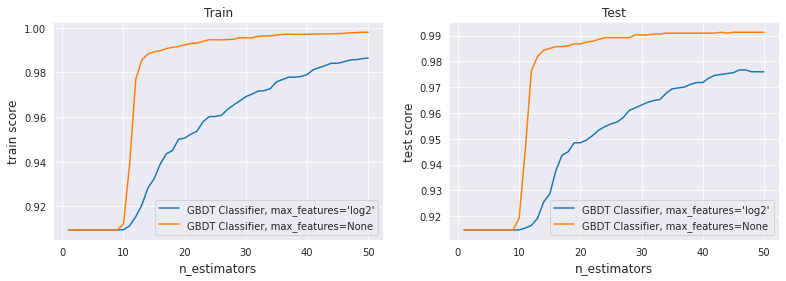

In [ ]:
# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)                                        

# Candidate regressors
ensemble_clfs = [
   
    ("GBDT Classifier, max_features='log2'", 
                GradientBoostingClassifier(loss = 'deviance',
                                        learning_rate = 0.05,
                                        criterion = 'friedman_mse',
                                        max_depth = 5,
                                        random_state = 42,
                                        max_features = 'log2',
                                        warm_start = True
                                        )),
    
     ("GBDT Classifier, max_features=None", 
                GradientBoostingClassifier(loss = 'deviance',
                                        learning_rate = 0.05,
                                        criterion = 'friedman_mse',
                                        max_depth = 5,
                                        random_state = 42,
                                        max_features = None,
                                        warm_start = True
                                        ))
]


score = { "GBDT Classifier, max_features='log2'": [],  "GBDT Classifier, max_features=None": []}

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 1
max_estimators = 50

for label, clf in ensemble_clfs:
    for i in tqdm(range(min_estimators, max_estimators + 1)):
        clf.set_params(n_estimators = i)
        clf.fit(x_train, y_train)
        score[label].append((i, clf.score(x_train, y_train), clf.score(x_test, y_test)))
        
    
# Plot train and test scores
fig, ax = plt.subplots(1, 2, figsize = (13, 4))

for label, info in score.items():
    i, train_score, test_score = zip(*info)
    ax[0].plot(i, train_score, label = label)
    ax[1].plot(i, test_score, label = label)
    
ax[0].set_xlabel("n_estimators", fontsize = 12)
ax[0].set_ylabel("train score", fontsize = 12)
ax[0].set_title('Train')
ax[0].legend(loc = 'lower right')

ax[1].set_xlabel("n_estimators", fontsize = 12)
ax[1].set_ylabel("test score", fontsize = 12)
ax[1].set_title('Test')
ax[1].legend(loc = 'lower right')

#### Too high! CAVEAT!
- Above result does NOT mean our model is doing well.
- The score is high, largely because we have a lot more (~ 10x) positive (churn) samples than negative ones. 

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(x_test)).ravel()
print('Model score (accuracy) is simply calculated as (tp+tn)/(tn+fp+fn+tp). So be careful!')

Model score (accuracy) is simply calculated as (tp+tn)/(tn+fp+fn+tp). So be careful!


In [ ]:
precision = tp/(tp+fp) # out of all pos predictions
sensitivity = tp/(tp+fn) # out of all pos samples

print('Our precision and sensitivity is {:.3f} and {:.3f}, both too high'.format(precision, sensitivity))

Our precision and sensitivity is 0.996 and 0.995, both too high


#### Simple Neural Network
- Weighted Cross Entropy is a great way to penalize samples with certain label of interest - negative labels, in our case.
- The loss would then be, label * -log(sigmoid(logits)) * pos_weight + (1 - label) * -log(1 - sigmoid(logits)), where pos_weight is less than 1.



In [ ]:
model = Sequential()
n_cols = x_train.shape[1]
BATCH_SIZE, EPOCHS = 1024, 50

model.add(Dense(units = 16, input_shape = (n_cols,), activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1))

adam = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = keras.losses.BinaryCrossentropy(), optimizer = adam, metrics = ['accuracy'])

# class weight define
neg, pos = np.bincount(y)
total = neg + pos
weight_0 = (1 / neg) * (total / 2.0)
weight_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_0, 1: weight_1}

model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, class_weight = class_weight)
loss, acc = model.evaluate(x_test, y_test)

Epoch 1/50
12/12 [==============================] - 1s 3ms/step - loss: 1.6215 - accuracy: 0.2409
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 1.1687 - accuracy: 0.3783
Epoch 3/50
12/12 [==============================] - 0s 2ms/step - loss: 0.9697 - accuracy: 0.4394
Epoch 4/50
12/12 [==============================] - 0s 2ms/step - loss: 0.8533 - accuracy: 0.4984
Epoch 5/50
12/12 [==============================] - 0s 2ms/step - loss: 0.7769 - accuracy: 0.5148
Epoch 6/50
12/12 [==============================] - 0s 2ms/step - loss: 0.7156 - accuracy: 0.5348
Epoch 7/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6800 - accuracy: 0.5608
Epoch 8/50
12/12 [==============================] - 0s 2ms/step - loss: 0.6607 - accuracy: 0.5925
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.6140
Epoch 10/50
12/12 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.6273
Epoch 11/50
12/12 [

In [ ]:
print('Model accuracy = {:.3f}'.format(acc))

Model accuracy = 0.968


#### Does our model predict negative ones better than before? -> Yes, slightly! Because:

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, (model.predict(x_test) > 0.5).astype(int)).ravel()
precision = tp/(tp+fp) # out of all pos predictions
sensitivity = tp/(tp+fn) # out of all pos samples

print('Before, we made 4.49 % error with negative samples, but now with weighted cross entropy, we reduced it down to 0.41 %')

Before, we made 4.49 % error with negative samples, but now with weighted cross entropy, we reduced it down to 0.41 %
